# Tutorial VII - Periodic Library Routing

Applied Optimization with Julia

# Introduction

Welcome to “FastDelivery” - a local logistics service in Hamburg! We’re
working with a central warehouse that operates a decentralized
distribution network: they deliver packages directly to smaller
distribution centers in the region, ensuring efficient last-mile
delivery across the area.

The central warehouse operates a fleet of delivery vehicles that
transport packages between their main hub and 14 partner distribution
centers scattered across the region. The challenge? Designing the most
efficient routing system to keep packages flowing smoothly while keeping
operational costs in check.

In this case study, we’ll help FastDelivery optimize their delivery
routes using the Capacitated Vehicle Routing Problem (CVRP) approach.
We’ll consider several real-world constraints like vehicle capacity
(measured in standard shipping containers), driving distances, and
operational costs to find the best possible delivery strategy.

------------------------------------------------------------------------

# 1. Implementing the basic CVRP

Implement the CVRP from the lecture without the constraints preventing
subtours and restricting the driving time and capacities.

The demand per distribution center and the coordinates of the locations
are provided as CSV files.

The number of vehicles is 6 and each vehicle can transport up to 50
parcels to the distribution centers. Note that capacity of each vehicle
is identical.

## Loading the data

First, we need to load the required packages and data files. Make sure
you have the following files in the `data` directory that is located in
the same directory as this notebook:

-   `routing-demand.csv`: Contains demand per distribution center
-   `coord_x_y.csv`: Contains location coordinates

In [1]:
using DelimitedFiles
using CSV
using DataFrames
using JuMP
using HiGHS
using Plots

## Prepare the model data
file_directory = "$(@__DIR__)/data"
demand = CSV.read("$(file_directory)/routing-demand.csv", DataFrame)
coord = CSV.read("$(file_directory)/coord_x_y.csv", DataFrame)

Row,location,x,y
,String7,Float64,Float64
1,central,155.24,151.63
2,dc_01,128.513,67.4002
3,dc_02,47.6949,194.738
4,dc_03,93.6483,181.213
5,dc_04,59.737,166.434
6,dc_05,197.681,102.756
7,dc_06,152.263,140.986
8,dc_07,183.943,182.649
9,dc_08,113.792,33.3626


> **Tip**
>
> Make sure that you have downloaded the data in the `data` folder that
> is located in the same directory as this notebook.

------------------------------------------------------------------------

## Define the parameters

First, define the number of vehicles and the capacity as parameters.
Name them `vehicles` and `capacity`.

In [2]:
# YOUR CODE BELOW
vehicles = 6
capacity = 50

50

In [3]:
# Test your code
@assert vehicles == 30/5 "Number of vehicles is incorrect"
@assert capacity == 100/2 "Capacity is incorrect"
println("Variables defined, great job!")

Variables defined, great job!


Now, we need to compute the distance matrix. You can do so by using the
Euclidean distance between the coordinates of the locations. Compute the
distance matrix for all locations and store it in a dictionary called
`distance`. Access each location by the tuple `(i,j)` where `i` is the
origin and `j` is the destination. **Hint: You need the distance from
each location to all other locations!**

In [4]:
# YOUR CODE BELOW
distance = Dict()

for i in 1:nrow(coord)
    for j in 1:nrow(coord)
        distance_between_x = coord.x[i] - coord.x[j]
        distance_between_y = coord.y[i] - coord.y[j]
        distance[(coord.location[i], coord.location[j])] = sqrt(distance_between_x^2 + distance_between_y^2)
    end
end

In [5]:
# Test your code
@assert length(distance) == nrow(coord) * nrow(coord) "Distance dictionary should have n² entries where n is the number of locations"
@assert all(v >= 0 for v in values(distance)) "All distances should be non-negative"
@assert all(isapprox(distance[(i,j)], distance[(j,i)]) for i in coord.location for j in coord.location if i != j) "Distances should be symmetric"
println("Distance dictionary test passed successfully, great job!")

Distance dictionary test passed successfully, great job!


------------------------------------------------------------------------

## Define the model

Next, we create the model instance. As this is a linear problem, we can
use the `HiGHS` solver.

In [6]:
# Create the model instance
cvrp_model = Model(HiGHS.Optimizer)
set_attribute(cvrp_model, "presolve", "on")
set_attribute(cvrp_model, "time_limit", 60.0)
set_attribute(cvrp_model, "mip_rel_gap", 0.0)

## Define the variables

Now you can start by defining the model variables. The variable we need
first is the binary decision variable `X` which indicates whether an arc
from node `i` to node `j` exists. To work with the decision variable,
you will need to work with a vector of locations.

In [7]:
# Vector of locations
println(demand.location)


String7["central", "dc_01", "dc_02", "dc_03", "dc_04", "dc_05", "dc_06", "dc_07", "dc_08", "dc_09", "dc_10", "dc_11", "dc_12", "dc_13", "dc_14"]


> **Tip**
>
> You could use the `demand.location` vector to define the elements of
> the decision variable `X`.

In [8]:
# YOUR CODE BELOW
@variable(cvrp_model, X[i in demand.location, j in demand.location], Bin)

2-dimensional DenseAxisArray{VariableRef,2,...} with index sets:
    Dimension 1, String7["central", "dc_01", "dc_02", "dc_03", "dc_04", "dc_05", "dc_06", "dc_07", "dc_08", "dc_09", "dc_10", "dc_11", "dc_12", "dc_13", "dc_14"]
    Dimension 2, String7["central", "dc_01", "dc_02", "dc_03", "dc_04", "dc_05", "dc_06", "dc_07", "dc_08", "dc_09", "dc_10", "dc_11", "dc_12", "dc_13", "dc_14"]
And data, a 15×15 Matrix{VariableRef}:
 X[central,central]  X[central,dc_01]  …  X[central,dc_13]  X[central,dc_14]
 X[dc_01,central]    X[dc_01,dc_01]       X[dc_01,dc_13]    X[dc_01,dc_14]
 X[dc_02,central]    X[dc_02,dc_01]       X[dc_02,dc_13]    X[dc_02,dc_14]
 X[dc_03,central]    X[dc_03,dc_01]       X[dc_03,dc_13]    X[dc_03,dc_14]
 X[dc_04,central]    X[dc_04,dc_01]       X[dc_04,dc_13]    X[dc_04,dc_14]
 X[dc_05,central]    X[dc_05,dc_01]    …  X[dc_05,dc_13]    X[dc_05,dc_14]
 X[dc_06,central]    X[dc_06,dc_01]       X[dc_06,dc_13]    X[dc_06,dc_14]
 X[dc_07,central]    X[dc_07,dc_01]       X[d

In [9]:
# Test your code
@assert size(X) == (15,15) "Have you defined the decision variable X?"
@assert all(is_binary(x) for x in X) "The decision variable X should be binary"
println("Decision variable X test passed successfully, great job!")

Decision variable X test passed successfully, great job!


------------------------------------------------------------------------

## Define the objective function

We want to minimize the total distance of the routes based on the
distance dictionary `distance` that you computed earlier. Create the
objective function.

In [10]:
# YOUR CODE BELOW
@objective(
    cvrp_model,
    Min,
    sum(X[i, j] * distance[(i, j)] for i in demand.location, j in demand.location if i != j)
)

88.3680381684265 X[central,dc_01] + 115.86280962059533 X[central,dc_02] + 68.32750940679274 X[central,dc_03] + 96.64334656891108 X[central,dc_04] + 64.72998065258508 X[central,dc_05] + 11.052673330633086 X[central,dc_06] + 42.26178953396257 X[central,dc_07] + 125.31959138438697 X[central,dc_08] + 70.81336145191403 X[central,dc_09] + 146.87842338816742 X[central,dc_10] + 22.577046895282262 X[central,dc_11] + 182.1412719680766 X[central,dc_12] + 156.75509748459663 X[central,dc_13] + 102.54474819621215 X[central,dc_14] + 88.3680381684265 X[dc_01,central] + 150.8193050668551 X[dc_01,dc_02] + 119.03279430666737 X[dc_01,dc_03] + 120.57279520333452 X[dc_01,dc_04] + 77.68023616484399 X[dc_01,dc_05] + 77.32289884992323 X[dc_01,dc_06] + 127.8854854841096 X[dc_01,dc_07] + 37.08459228188137 X[dc_01,dc_08] + 46.71097089083383 X[dc_01,dc_09] + 65.09140154513462 X[dc_01,dc_10] + 85.41908156672083 X[dc_01,dc_11] + 100.25109365081954 X[dc_01,dc_12] + 82.22169752583291 X[dc_01,dc_13] + 70.15132120354255

In [11]:
# Test your code
obj = objective_function(cvrp_model)
@assert typeof(obj) <: GenericAffExpr "Objective should be a linear expression"
@assert length(obj.terms) > 0 "Objective should not be empty"
println("Objective function defined successfully, great job!")
println("Note, that it is not tested whether the objective function is correct!")

Objective function defined successfully, great job!
Note, that it is not tested whether the objective function is correct!


------------------------------------------------------------------------

## Define the constraints

Create the two set of constraints that ensure that each location is
visited exactly once. **Note that the central location is indexed as
`"central"`!** We don’t need to consider the central location for the
constraints and we have to ensure during summing that we don’t include
the pairs where `i == j`.

In [12]:
# YOUR CODE BELOW
@constraint(
    cvrp_model,
    outgoing_nodes[i in demand.location; i != "central"],
    sum(X[i, j] for j in demand.location if i != j && j != "central") == 1
)

@constraint(
    cvrp_model,
    incoming_nodes[j in demand.location; j != "central"],
    sum(X[i, j] for i in demand.location if i != j && i != "central") == 1
)

JuMP.Containers.SparseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}, 1, Tuple{String7}} with 14 entries:
  [dc_01]  =  incoming_nodes[dc_01] : X[dc_02,dc_01] + X[dc_03,dc_01] + X[dc_04,dc_01] + X[dc_05,dc_01] + X[dc_06,dc_01] + X[dc_07,dc_01] + X[dc_08,dc_01] + X[dc_09,dc_01] + X[dc_10,dc_01] + X[dc_11,dc_01] + X[dc_12,dc_01] + X[dc_13,dc_01] + X[dc_14,dc_01] == 1
  [dc_02]  =  incoming_nodes[dc_02] : X[dc_01,dc_02] + X[dc_03,dc_02] + X[dc_04,dc_02] + X[dc_05,dc_02] + X[dc_06,dc_02] + X[dc_07,dc_02] + X[dc_08,dc_02] + X[dc_09,dc_02] + X[dc_10,dc_02] + X[dc_11,dc_02] + X[dc_12,dc_02] + X[dc_13,dc_02] + X[dc_14,dc_02] == 1
  [dc_03]  =  incoming_nodes[dc_03] : X[dc_01,dc_03] + X[dc_02,dc_03] + X[dc_04,dc_03] + X[dc_05,dc_03] + X[dc_06,dc_03] + X[dc_07,dc_03] + X[dc_08,dc_03] + X[dc_09,dc_03] + X[dc_10,dc_03] + X[dc_11,dc_03] + X[dc_12,dc_03] + X[dc_13,dc_03] + X[dc_14,dc_03]

In [13]:
# Test your code
const_refs = all_constraints(cvrp_model, include_variable_in_set_constraints=false)
num_constraints_in_model = length(const_refs)
expected_constraints = 2 * (nrow(demand) - 1)  # indegree + outdegree for all nodes except central
@assert num_constraints_in_model == expected_constraints "Number of constraints is incorrect as it is $(num_constraints_in_model) instead of $(expected_constraints)."
println("Constraints for the inflow and outflow defined, great job!")

Constraints for the inflow and outflow defined, great job!


Next, we need to restrict the ingoing and outgoing flows to the
`central` location. Create the two constraints that ensure that the
number of vehicles arriving and leaving the central location is equal to
the number of vehicles.

In [14]:
# YOUR CODE BELOW
@constraint(
    cvrp_model,
    outgoing_flow,
    sum(X["central", j] for j in demand.location if j != "central") == vehicles
)

@constraint(
    cvrp_model,
    incoming_flow,
    sum(X[i, "central"] for i in demand.location if i != "central") == vehicles
)


incoming_flow : X[dc_01,central] + X[dc_02,central] + X[dc_03,central] + X[dc_04,central] + X[dc_05,central] + X[dc_06,central] + X[dc_07,central] + X[dc_08,central] + X[dc_09,central] + X[dc_10,central] + X[dc_11,central] + X[dc_12,central] + X[dc_13,central] + X[dc_14,central] == 6

In [15]:
# Test your code
const_refs = all_constraints(cvrp_model, include_variable_in_set_constraints=false)
num_constraints_in_model = length(const_refs)
expected_constraints = 2 * (nrow(demand) - 1) + 2  # indegree + outdegree for all nodes except central + 2 for inflow and outflow
@assert num_constraints_in_model == expected_constraints "Number of constraints is incorrect as it is $(num_constraints_in_model) instead of $(expected_constraints)."
println("Constraints for the inflow and outflow defined, great job!")

Constraints for the inflow and outflow defined, great job!


------------------------------------------------------------------------

## Solve the model

Now, we can solve the model. This should work very fast, as the model is
very simple without any subtour elimination constraints. Solve the model
as usual.

In [16]:
# YOUR CODE BELOW
optimize!(cvrp_model)

Running HiGHS 1.12.0 (git hash: 755a8e027): Copyright (c) 2025 HiGHS under MIT licence terms
MIP has 30 rows; 225 cols; 392 nonzeros; 225 integer variables (225 binary)
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [1e+01, 2e+02]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 6e+00]
Presolving model
30 rows, 210 cols, 392 nonzeros  0s
30 rows, 210 cols, 392 nonzeros  0s
Presolve reductions: rows 30(-0); columns 210(-15); nonzeros 392(-0) 

Solving MIP model with:
   30 rows
   210 cols (210 binary, 0 integer, 0 implied int., 0 continuous, 0 domain fixed)
   392 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial zero

        Nodes      |    B&B Tree     | 

In [17]:
# This defines a function that prints the status of the model
function print_model_status(model)
    begin
        if termination_status(model) == OPTIMAL
            println("Great, the solution is optimal.")
            println("The relative gap is $(relative_gap(model))")
            println("The solve time (in seconds) is $(solve_time(model))")
        elseif termination_status(model) == TIME_LIMIT && has_values(model)
            println("Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("The model was not solved correctly.")
        end
        println("The objective value is ", objective_value(model))
    end
end

# Test your code
@assert termination_status(cvrp_model) == OPTIMAL "The model should be optimal. Have you have any mistakes in the model formulation?"
print_model_status(cvrp_model)
println("Model solved successfully, great job!")

Great, the solution is optimal.
The relative gap is 0.0
The solve time (in seconds) is 0.014464139938354492
The objective value is 1150.6674670084878
Model solved successfully, great job!


------------------------------------------------------------------------

## Plot the results

The following part extracts the results to plot the tours and requires
no changes on your part. It defines some functions that are used to plot
the results.

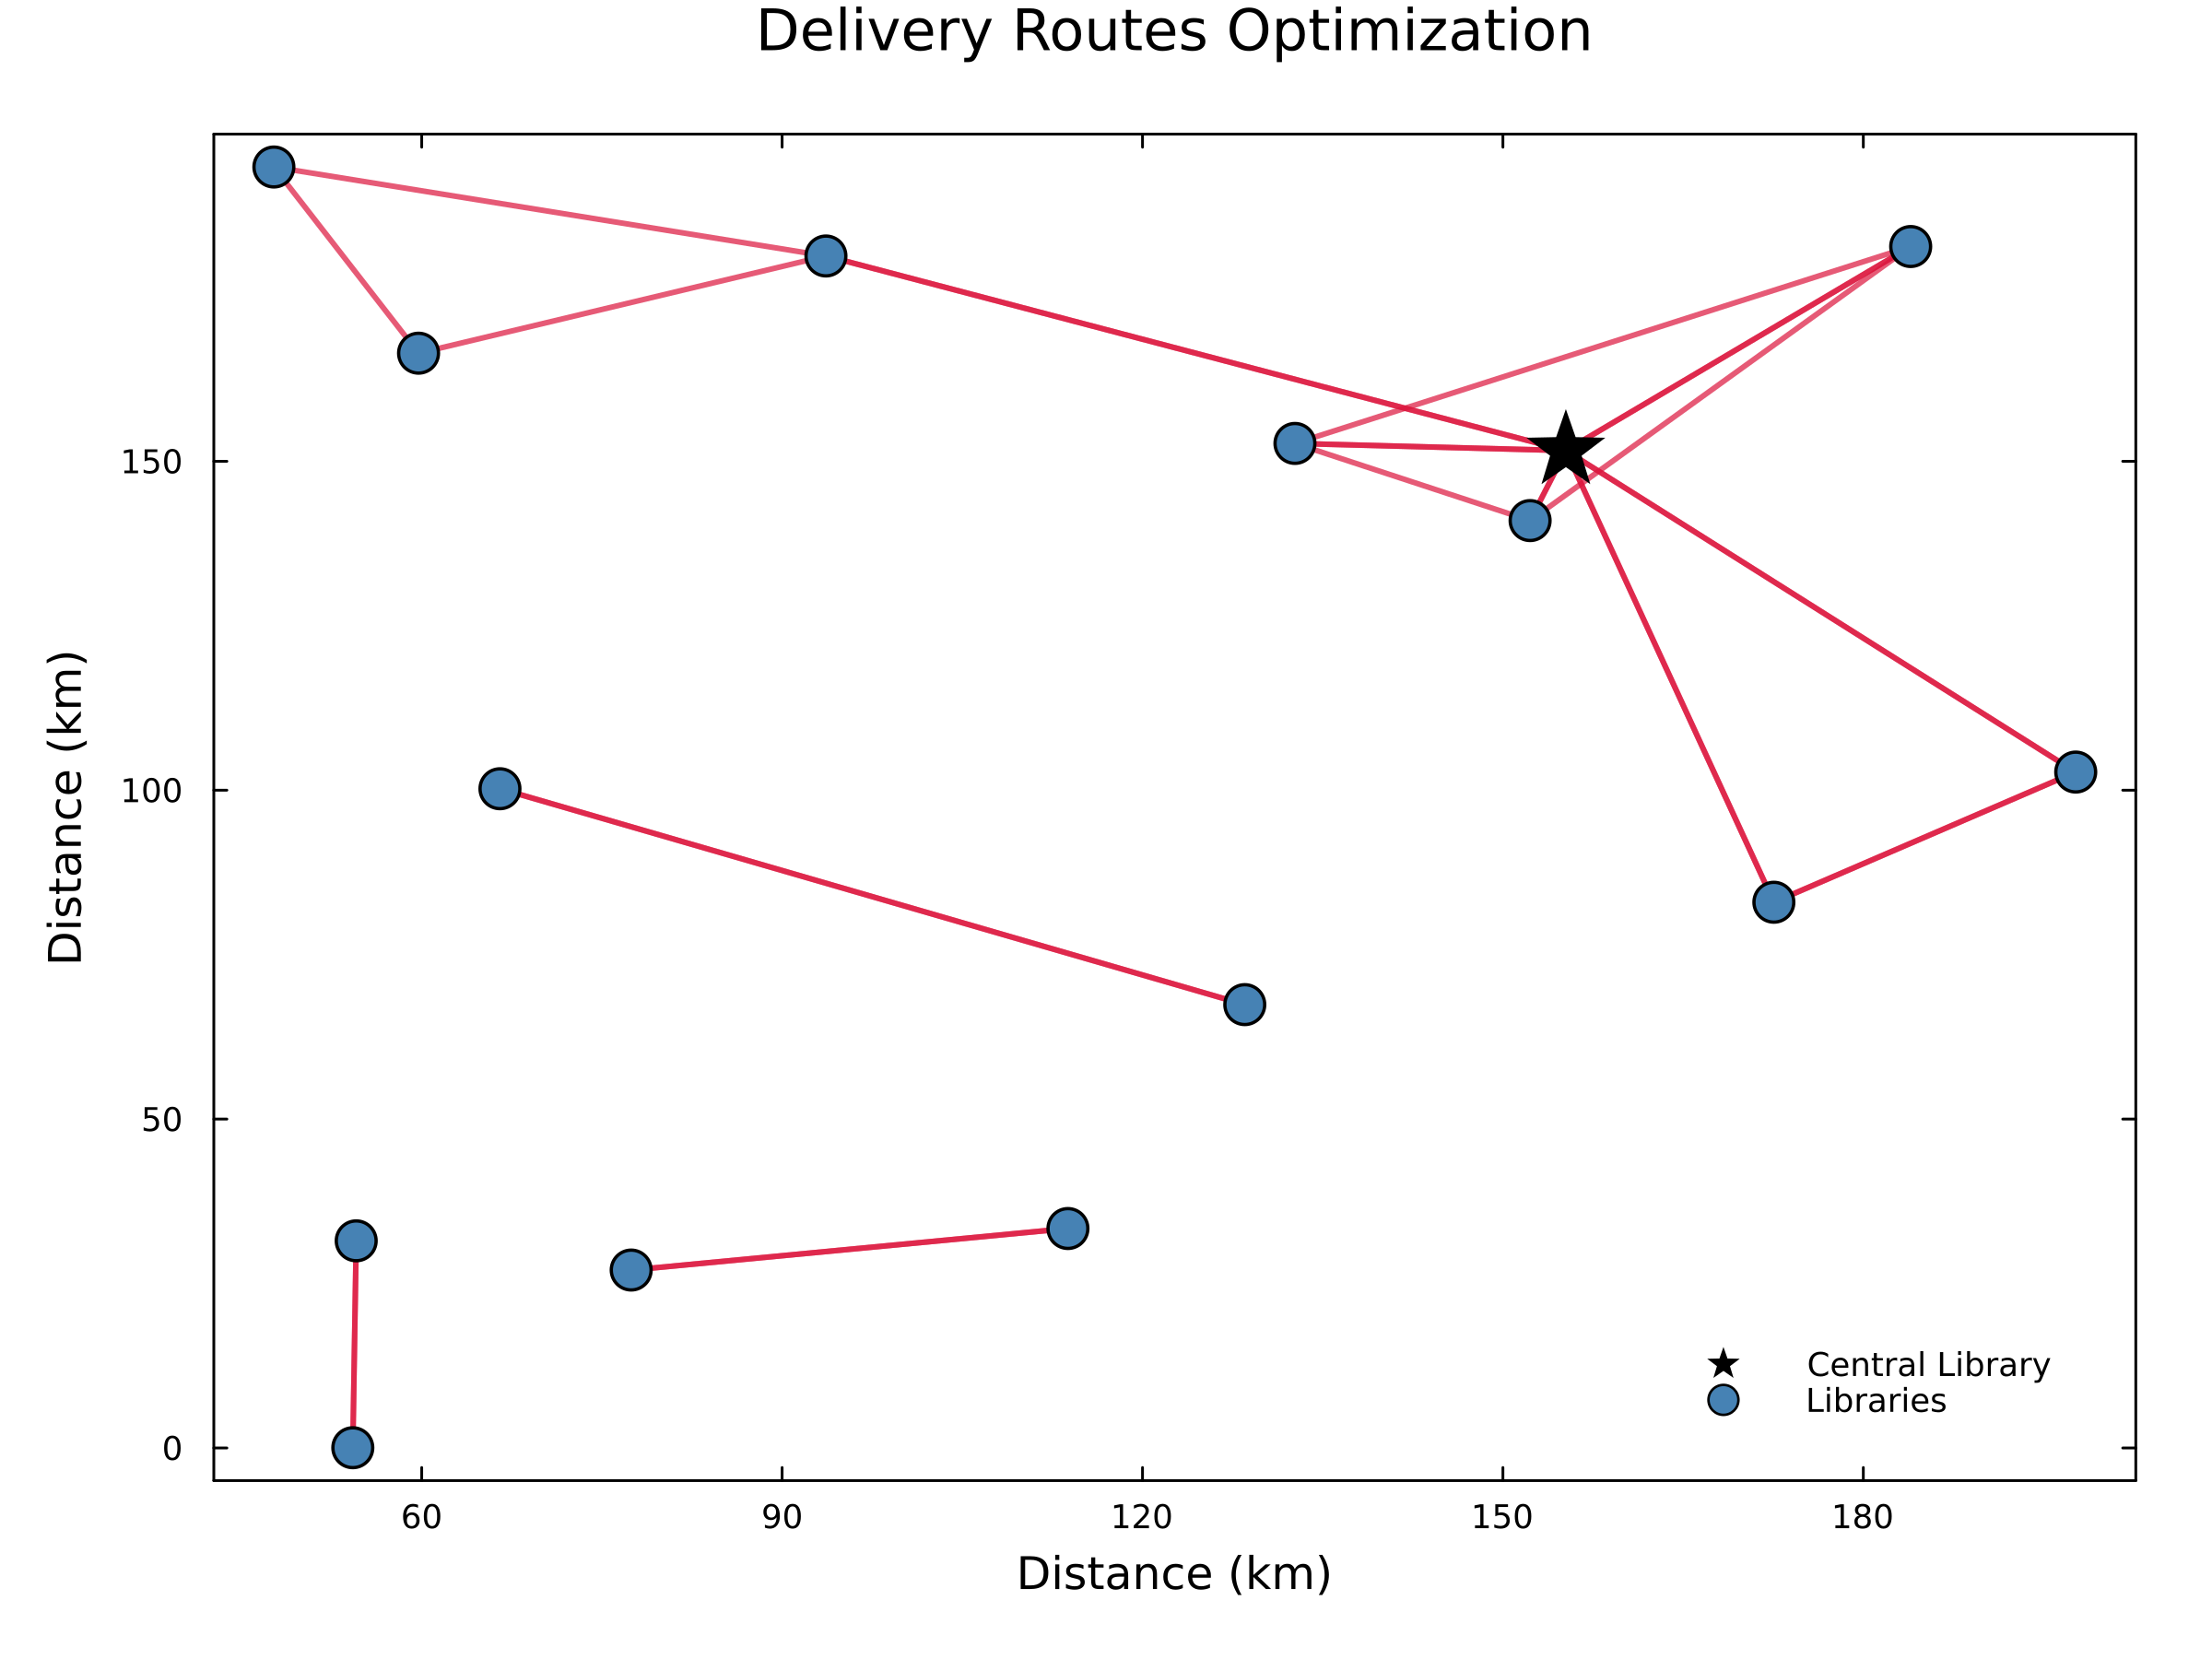

In [18]:
function plot_routes(X, coord)

    Routes = [value(X[i,j]) >= 0.5 ? true : false for i in coord.location, j in coord.location]

    fig = plot(
        size=(800, 600),
        background_color=:white,
        framestyle=:box,
        grid=false,
        dpi=300
    )

    connections = findall(Routes -> !iszero(Routes), Routes .>= 0.5)

    for conn in connections
        xx = [coord[conn[1],:x]; coord[conn[2],:x]]
        yy = [coord[conn[1],:y]; coord[conn[2],:y]]
        plot!(
            fig, xx, yy,
            color=:crimson,
            label="",
            linewidth=2,
            linestyle=:solid,
            alpha=0.7
        )
    end

    scatter!(
        fig, coord[1:1,:x], coord[1:1,:y],
        marker=:star5,
        color=:black,
        markersize=15,
        label="Central Library",
        markerstrokewidth=1
    )
    scatter!(
        fig, coord[2:end,:x], coord[2:end,:y],
        marker=:circle,
        color=:steelblue,
        markersize=8,
        label="Libraries",
        markerstrokewidth=1
    )

    plot!(
        fig,
        title="Delivery Routes Optimization",
        xlabel="Distance (km)",
        ylabel="Distance (km)",
        legend=:bottomright,
        legendfontsize=8,
        foreground_color_legend=nothing,
        background_color_legend=:transparent,
        margin=5Plots.mm,
        xlims=(minimum(coord.x) - 5, maximum(coord.x) + 5),
        ylims=(minimum(coord.y) - 5, maximum(coord.y) + 5)
    )

    return fig
end

# Plot the routes
display(plot_routes(X,coord))

------------------------------------------------------------------------

# 2. Subtour elimination

As you see in the plot, the solution contains subtours. Thus, we need to
add some constraints from the Miller-Tucker-Zemlin (MTZ) formulation to
prevent subtours. First, we need to define the variable `U` which is the
current capacity usage at node `i`.

> **Tip**
>
> It might be useful to convert the `demand` DataFrame into a
> dictionary, so we can access the demand for each location directly by
> the location name for the variable definition and the constraints.

Create the variable `U` and ensure that the capacity usage at each
location is between the demand and the capacity. Note, that a dictionary
might be useful here.

In [27]:
# YOUR CODE BELOW
dictDemand = Dict(demand.location .=> demand.demand)

@variable(
    cvrp_model,
    U[i in keys(dictDemand)] >= dictDemand[i];
    upper_bound = capacity
)

1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, String7["central", "dc_02", "dc_04", "dc_07", "dc_11", "dc_03", "dc_08", "dc_10", "dc_01", "dc_05", "dc_12", "dc_09", "dc_14", "dc_06", "dc_13"]
And data, a 15-element Vector{VariableRef}:
 U[central]
 U[dc_02]
 U[dc_04]
 U[dc_07]
 U[dc_11]
 U[dc_03]
 U[dc_08]
 U[dc_10]
 U[dc_01]
 U[dc_05]
 U[dc_12]
 U[dc_09]
 U[dc_14]
 U[dc_06]
 U[dc_13]

In [28]:
# Test your code
demand_dict = Dict(demand.location .=> demand.demand)
@assert all(has_lower_bound(U[i]) == true for i in demand.location) "The variable U should have a lower bound"
@assert all(has_upper_bound(U[i]) == true for i in demand.location) "The variable U should have an upper bound"
println("Variable U defined successfully, great job!")

Variable U defined successfully, great job!


Next, we need to add the set of constraints to prevent subtours.

In [29]:
# YOUR CODE BELOW
@constraint(
    cvrp_model,
    subtour_elimination[i in keys(dictDemand), j in keys(dictDemand); i != j && i != "central" && j != "central"],
    U[i] - U[j] + capacity * X[i, j] <= capacity - dictDemand[j]
)

JuMP.Containers.SparseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}, 2, Tuple{String7, String7}} with 182 entries:
  [dc_02, dc_04]  =  subtour_elimination[dc_02,dc_04] : 50 X[dc_02,dc_04] + U[dc_02] - U[dc_04] <= 48
  [dc_02, dc_07]  =  subtour_elimination[dc_02,dc_07] : 50 X[dc_02,dc_07] + U[dc_02] - U[dc_07] <= 48
  [dc_02, dc_11]  =  subtour_elimination[dc_02,dc_11] : 50 X[dc_02,dc_11] + U[dc_02] - U[dc_11] <= 38
  [dc_02, dc_03]  =  subtour_elimination[dc_02,dc_03] : 50 X[dc_02,dc_03] + U[dc_02] - U[dc_03] <= 47
  [dc_02, dc_08]  =  subtour_elimination[dc_02,dc_08] : 50 X[dc_02,dc_08] + U[dc_02] - U[dc_08] <= 43
  [dc_02, dc_10]  =  subtour_elimination[dc_02,dc_10] : 50 X[dc_02,dc_10] + U[dc_02] - U[dc_10] <= 43
  [dc_02, dc_01]  =  subtour_elimination[dc_02,dc_01] : 50 X[dc_02,dc_01] + U[dc_02] - U[dc_01] <= 45
  [dc_02, dc_05]  =  subtour_elimination[dc_02,dc_05] :

In [30]:
# Test your code
println("Constraints for the subtour elimination defined!")
println("It is not tested whether the constraints are correct, so please check the resulting routes in the visualization.")

Constraints for the subtour elimination defined!
It is not tested whether the constraints are correct, so please check the resulting routes in the visualization.


Now, solve the model again.

In [31]:
# YOUR CODE BELOW
optimize!(cvrp_model)

MIP has 212 rows; 255 cols; 938 nonzeros; 225 integer variables (225 binary)
Coefficient ranges:
  Matrix  [1e+00, 5e+01]
  Cost    [1e+01, 2e+02]
  Bound   [1e+00, 5e+01]
  RHS     [1e+00, 5e+01]
Presolving model
212 rows, 224 cols, 938 nonzeros  0s
212 rows, 224 cols, 938 nonzeros  0s
Presolve reductions: rows 212(-0); columns 224(-31); nonzeros 938(-0) 

Solving MIP model with:
   212 rows
   224 cols (210 binary, 0 integer, 0 implied int., 14 continuous, 0 domain fixed)
   938 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic;
     I => Shifting; J => Feasibility jump; L => Sub-MIP; P => Empty MIP; R => Randomized rounding;
     S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution; Y => HiGHS solution;
     Z => ZI Round; l => Trivial lower; p => Trivial point; u => Trivial upper; z => Trivial zero

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src 

The following code prints the model status and visualizes the routes. If
your implementation is correct, the routes should be free of subtours
and the model should have reached optimality or found a feasible
solution before hitting the time limit.

In [32]:
print_model_status(cvrp_model)
display(plot_routes(X,coord))

LoadError: The model was not solved correctly.

The following code plots the capacity usage per vehicle.

In [ ]:
# Plot the capacity usage
function plot_capacity_usage(X, U, coord)
    # Find which locations are visited by each vehicle from central
    vehicle_routes = []
    for i in coord.location
        if value(X[i, "central"]) > 0.5
            push!(vehicle_routes, (i, value(U[i])))
        end
    end

    println(vehicle_routes)

    # Sort by capacity usage for better visualization
    sort!(vehicle_routes, by = x -> x[2])

    # Create bar plot
    fig = bar(
        [u[2] for u in vehicle_routes],
        title="Capacity Usage per Vehicle",
        xlabel="Vehicle",
        ylabel="Capacity Usage (parcels)",
        label="",
        color=:steelblue,
        ylims=(0, capacity),
        size=(800, 400),
        dpi=300,
        margin=5Plots.mm,
    )

    # Add capacity limit line
    hline!([capacity], color=:red, linestyle=:dash, label="Capacity Limit")

    return fig
end

# Create and display the plot
display(plot_capacity_usage(X, U, coord))

------------------------------------------------------------------------

# 3. Computing the costs

FastDelivery wants to know the costs of the optimal solution. Let’s
calculate the monthly operational costs based on the following
parameters:

-   Cost per kilometer: 0.6 EUR (includes fuel, repairs, driver costs)
-   Service frequency: Monday to Friday (5 days per week)
-   Time period: 4 weeks
-   Vehicle lease cost: 450 EUR per vehicle per 4 weeks

Calculate the total monthly costs and store them in `monthly_costs`.

In [ ]:
# YOUR CODE BELOW

In [ ]:
# Test your code
@assert isapprox(monthly_costs, 14168, atol=10) "The costs are not as expected. But don't worry, you can still get the bonus points!"
println("Costs calculated as $(monthly_costs) EUR successfully, great job!")

------------------------------------------------------------------------

# 4. Optimal Solution?

Although the costs can now be computed, the tour plan has not changed so
far. FastDelivery asks you whether you have an idea of how to lower the
costs associated with the parcel distribution. Take a look at your
current plotted solution and try to come up with an idea. Discuss the
potential shortcoming and assumptions of the current model in a few
sentences. Propose at least one idea of how to lower the costs in the
future.

You can do this in a comment in the cell below.

In [ ]:
#=




=#

------------------------------------------------------------------------

# 5. Number of Vehicles

Together, you realize one potential area of improvement involves the
number of vehicles: it might potentially not be necessary to have 6
vehicles which deliver the parcels to the distribution centers. You are
thus tasked to find the optimal number of vehicles and the best tour
plan to minimize the costs **(not the distance!)**.

> **Tip**
>
> There are multiple ways to tackle this task, but I recommend to first
> think about how to model the fixed costs for the vehicles and how to
> add the costs for the driving distance. If you need to adjust the
> model, feel free to do so. The easiest way then would be the
> definition of a new model (e.g. `cvrp_model_flex`) and then to copy
> and adjust all relevant constraints and variables.

Implement these changes in your model and compute the optimal number of
vehicles and the best tour plan. In case the computation takes too long,
no worries! If you define the model with a time limit of 60 seconds, it
should not take too long.

In [ ]:
# YOUR CODE BELOW

The code below again visualizes the results. Note, that you might need
to replace the `X` and `U` with your new models variable names, if you
have renamed them.

In [ ]:
# Visualize the results
print_model_status(cvrp_model_flex)
display(plot_routes(X,coord))

Based on your results, what are the expected costs savings when compared
to task b, and how many vehicles does the central library need?

Please answer this question in the cell below.

In [ ]:
#=



=#

------------------------------------------------------------------------

# Solutions

You will likely find solutions to most exercises online. However, I
strongly encourage you to work on these exercises independently without
searching explicitly for the exact answers to the exercises.
Understanding someone else’s solution is very different from developing
your own. Use the lecture notes and try to solve the exercises on your
own. This approach will significantly enhance your learning and
problem-solving skills.

Remember, the goal is not just to complete the exercises, but to
understand the concepts and improve your programming abilities. If you
encounter difficulties, review the lecture materials, experiment with
different approaches, and don’t hesitate to ask for clarification during
class discussions.